### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
all_metrics = settings_dict["all_metrics"]

In [6]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [7]:
features = features.sample(frac=1)

In [8]:
y_df = features["class"]
X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)

In [9]:
y = y_df.to_numpy()
X = X_df.to_numpy()

### 1. Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [11]:
clf = IsolationForest(max_samples=100, contamination=0.1, random_state=100)
clf.fit(X) #, sample_weight=1.0/(Xfixed[:,2,:])**2)
scores_pred_Norm = clf.decision_function(X)
#scores_pred_Norm = clf.score_samples(X)
#.sample_score(X)

threshold_Norm  = stats.scoreatpercentile(scores_pred_Norm ,100 * 0.1)
y_predNorm = clf.predict(X)

In [12]:
abornmality = -scores_pred_Norm
iforest_df = pd.DataFrame(abornmality, columns=["abnormality"]) # higher is more abnormal
iforest_df.index.name = "sample_num"
iforest_df=iforest_df.sort_values(by="abnormality", ascending=False)

In [13]:
iforest_df

,abnormality
sample_num,
817,0.146213
2157,0.138299
1969,0.128877
157,0.122814
2543,0.118233
...,...
1220,-0.135107
1320,-0.135398
1806,-0.135956


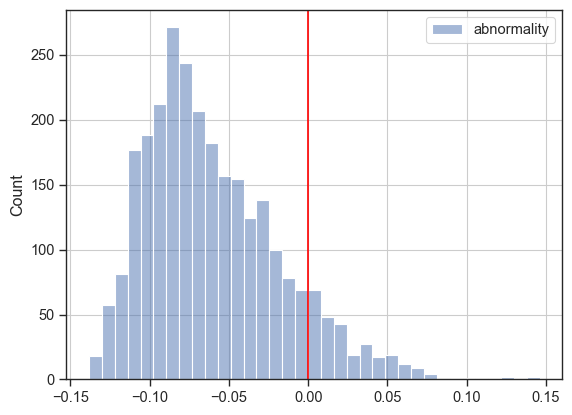

In [14]:
sns.histplot(iforest_df)
plt.axvline(x=0, color="red",label="outlier boundary")
plt.show()

### 2. EDA Distance Distributions across:
- n objects
- m metrics
- k clusters

![https://i.imgur.com/pmOqUZM.png](https://i.imgur.com/pmOqUZM.png)

In [15]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X,y)

DistanceMetricClassifier()

In [16]:
dist_df_dict = {}
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df['minimum_distance'] = dist_df.min(axis=1)
    dist_df['median_distance'] = dist_df.min(axis=1)
    
    dist_df.index.name = "sample_num"
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
n_metrics = len(all_metrics)
clusters = np.unique(y)
n_clusters =len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=2732
m: n_metrics=18
k: n_clusters=4


In [18]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(all_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i,f"{cluster}_dist"]

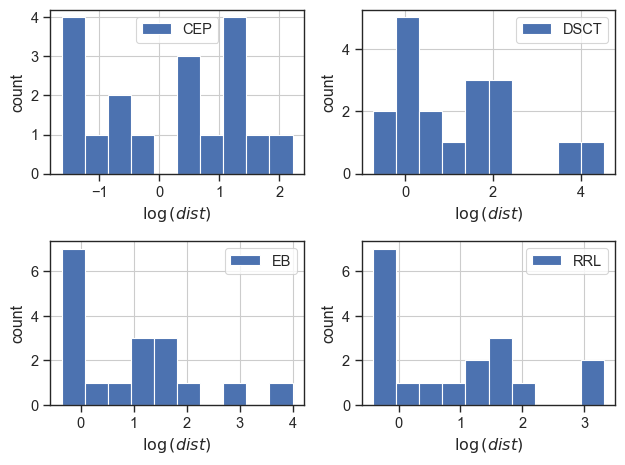

In [19]:
objnum = np.random.randint(1000)
# one cluster each plot
# all distance metrics in each plot

fig, ax = plt.subplots(2,2)
axs = ax.ravel()
for j, cluster in enumerate(clusters):
    axs[j].hist(np.log10(dist_df_arr[objnum,j,:]), label=cluster)
    # axs[j].set_xscale("log")
    axs[j].legend()
    axs[j].set_xlabel(r"$\log{(dist)}$")
    axs[j].set_ylabel("count")
plt.tight_layout()
plt.show()

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_12746/1282755283.py:4: RuntimeWarning: invalid value encountered in log10
  sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])


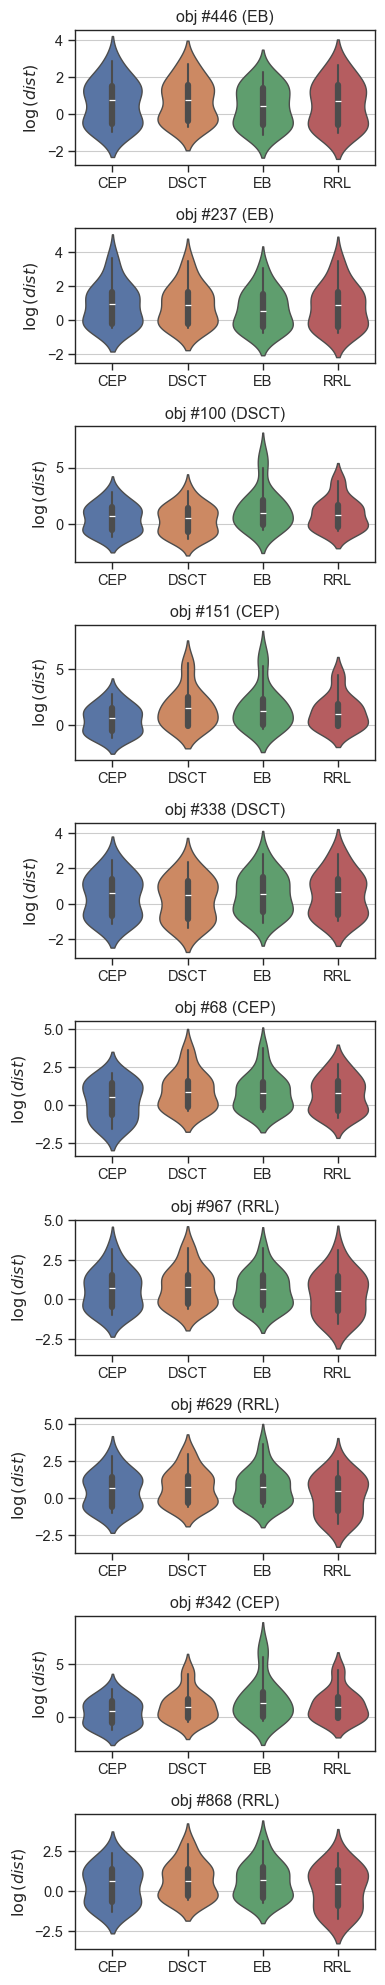

In [58]:
fig, axs = plt.subplots(10, 1, figsize=(4, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    axs[i].set_ylabel(r"$\log{(dist)}$")
    axs[i].set_title(f"obj #{objnum} ({y[objnum]})")
plt.tight_layout()
plt.show()

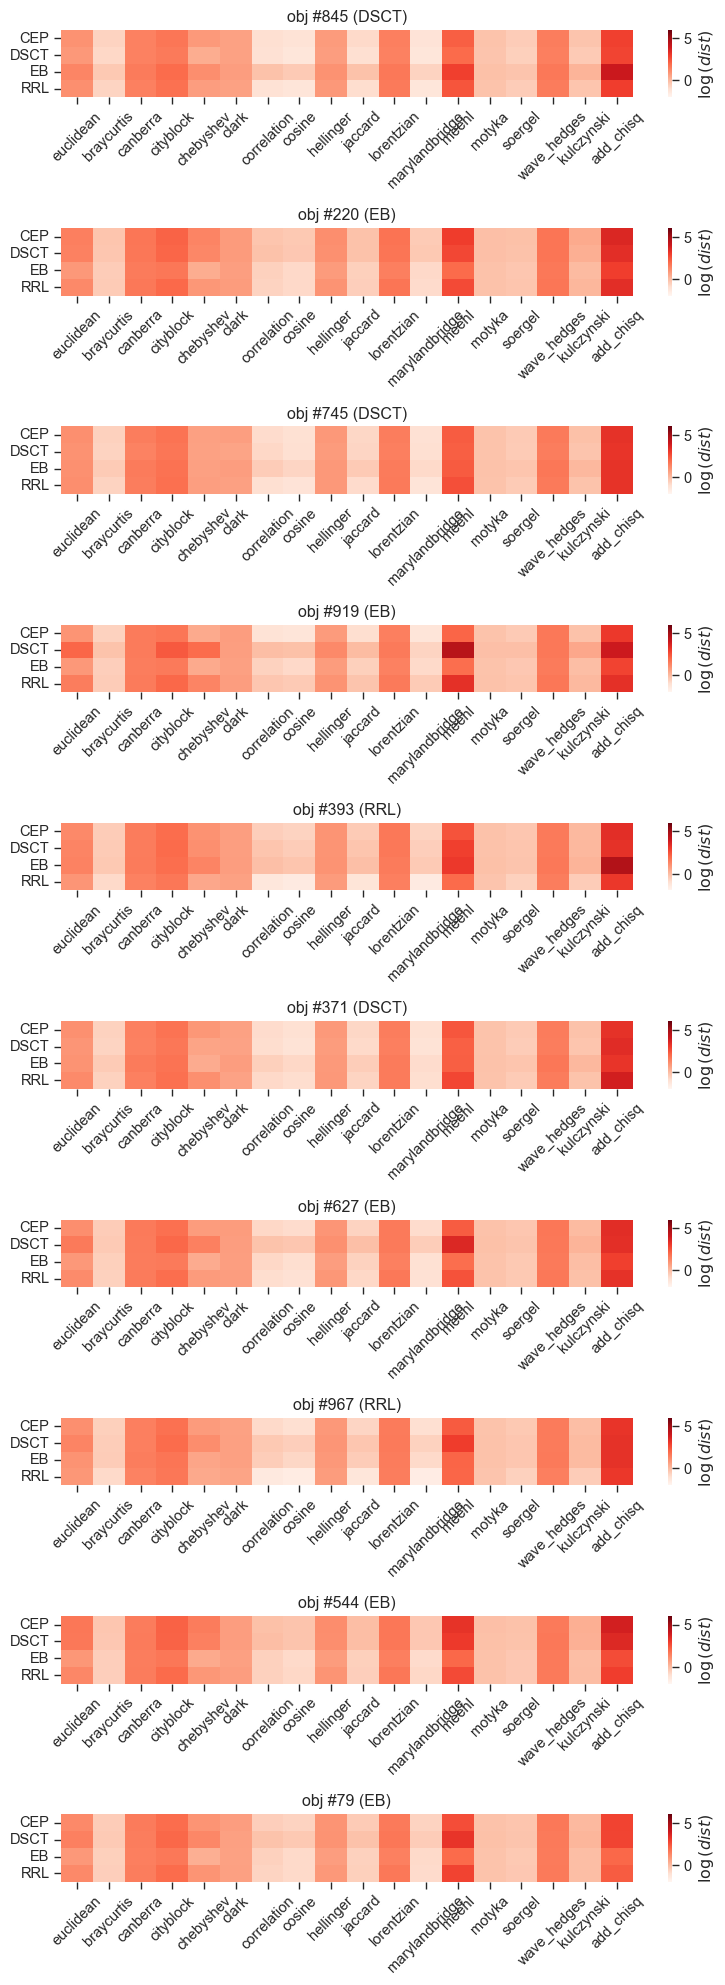

In [83]:
fig, axs = plt.subplots(10, 1, figsize=(8, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=all_metrics),cmap="Reds",ax=axs[i], 
                vmin=-2, vmax=6, cbar_kws={'label': r"$\log{(dist)}$"})
    axs[i].set_title(f"obj #{objnum} ({y[objnum]})")
    axs[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

## 3. DCPY

In [88]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [117]:
min_dists_across_clusters = []
median_dists_across_clusters = []

for metric in all_metrics:
    metric_str = utils.get_metric_name(metric)
    dist_df = dist_df_dict[metric_str]
    min_dists_across_clusters.append(dist_df["minimum_distance"].to_numpy())
    median_dists_across_clusters.append(dist_df["median_distance"].to_numpy())

min_dists_across_clusters = np.array(min_dists_across_clusters)
median_dists_across_clusters = np.array(median_dists_across_clusters)

In [116]:
dists_aggregate_dict[metric_str]["min"] = np.min(min_dists_across_clusters,axis=0)
dists_aggregate_dict[metric_str]["p25"] = np.percentile(min_dists_across_clusters, 25, axis=0)

(2732,)

In [103]:
min_dists_across_clusters.shape

(18, 2732)

In [ ]:
min_across_metrics_ = 

(2732,)

In [108]:
score1

array([0.05848517, 0.04348652, 0.05912054, ..., 0.02036826, 0.0387885 ,
       0.10415555])

In [90]:
iforest_df

,abnormality
sample_num,
817,0.146213
2157,0.138299
1969,0.128877
157,0.122814
2543,0.118233
...,...
1220,-0.135107
1320,-0.135398
1806,-0.135956


---

In [ ]:
def give_snid(objnum):
    snid = y_df.index[objnum]
    print(f"Class of obj #{objnum} (snid {snid}): {y_df[snid]}")
    return snid

In [79]:
snid = give_snid()

'CEP'

In [84]:
lcdf = pd.read_parquet("data/plotdf.parquet")
lcdf.index.name = "snid"

In [85]:
band_colors = {"u": sns.color_palette()[0],
"g": sns.color_palette()[1],
"r": sns.color_palette()[2],
"i": sns.color_palette()[3],
"z": sns.color_palette()[4],
"Y": sns.color_palette()[5]}

In [86]:
y_df.to_csv("indices.csv",index=True)

In [87]:
def plot_lc(lcdf, snid):
    chosen_df = lcdf.loc[snid]
    cols = ["MJD", "FLUXCAL", "FLUXCALERR", "BAND", "PHOTFLAG", "ZEROPT"]
    dat = []
    
    for col in cols:
        if col in cols:
            dat.append(chosen_df.loc[col])
    dat = np.array(dat).T
    lc = pd.DataFrame(data=dat,columns=cols).sort_values(by="MJD")

    defsize = (8, 4)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=defsize, sharey=False)
    
    for band in "ugrizY":
        color = band_colors[band]
        lc_band = lc[lc["BAND"] == band]

        mjd_band = lc_band["MJD"].to_numpy()
        flux_band = lc_band["FLUXCAL"].to_numpy()
        fluxerr_band = lc_band["FLUXCALERR"].to_numpy()
    
        period = X_df.loc[snid]["Multiband_period"]
        folded_mjd_band = np.mod(mjd_band, period)
        phase_band = folded_mjd_band / period

        
        ax0.errorbar(
            x=mjd_band,
            y=flux_band,
            yerr=fluxerr_band,
            c=color,
            fmt="o",
            label=f"{band}",
        )

        ax1.errorbar(x=phase_band, y=flux_band, c=color, yerr=fluxerr_band, fmt=".", ms=5)
        ax1.errorbar(
            x=phase_band + 1, y=flux_band, c=color, yerr=fluxerr_band, fmt=".", ms=5, label=band,
        )
    
    ax0.set_xlabel("Time (in days)")
    ax1.set_xlabel("Phase")
    ax1.set_ylabel("Brightness (flux)")
    ax0.set_ylabel("Brightness (flux)")
    plt.legend()
    # plt.title(f"OID {objid} ({cur_cl})")
    # plt.xlim(peak_mjd - 40, peak_mjd + 90)
    # plt.grid()
    # plt.savefig("rawlc_crop.pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()

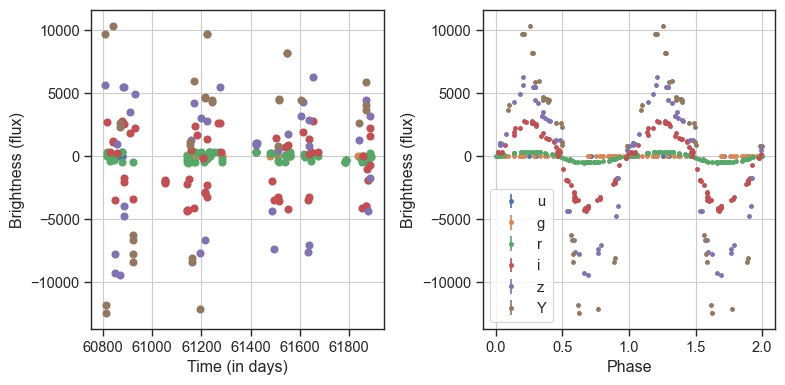

In [88]:
plot_lc(lcdf,56961335)

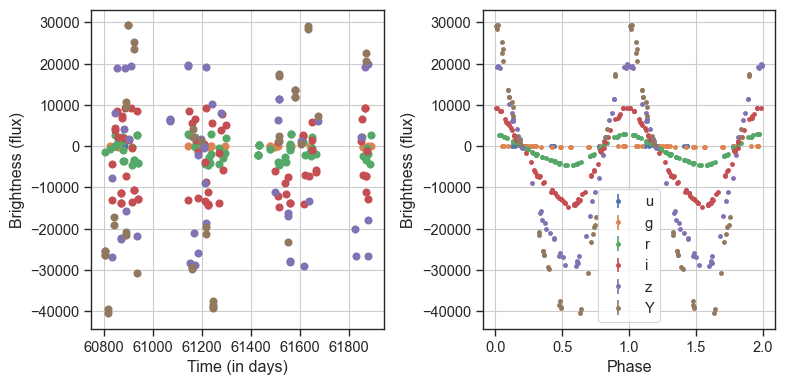

In [89]:
plot_lc(lcdf, 1067946)

In [ ]:
plot_lc(lcdf, 1067946)